In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

In [2]:
data_train = pd.read_csv('dataset/train.csv')

1.8828757597682129


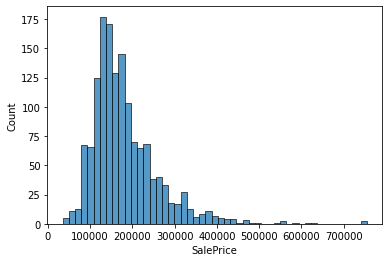

In [3]:
sns.histplot(data_train['SalePrice'])
# sns.displot(data_train['SalePrice'], kind='hist')

# If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
# If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed
# If the skewness is less than -1 or greater than 1, the data are highly sprint(type(saleprice_scaled))kewed
print(data_train['SalePrice'].skew())

<AxesSubplot:>

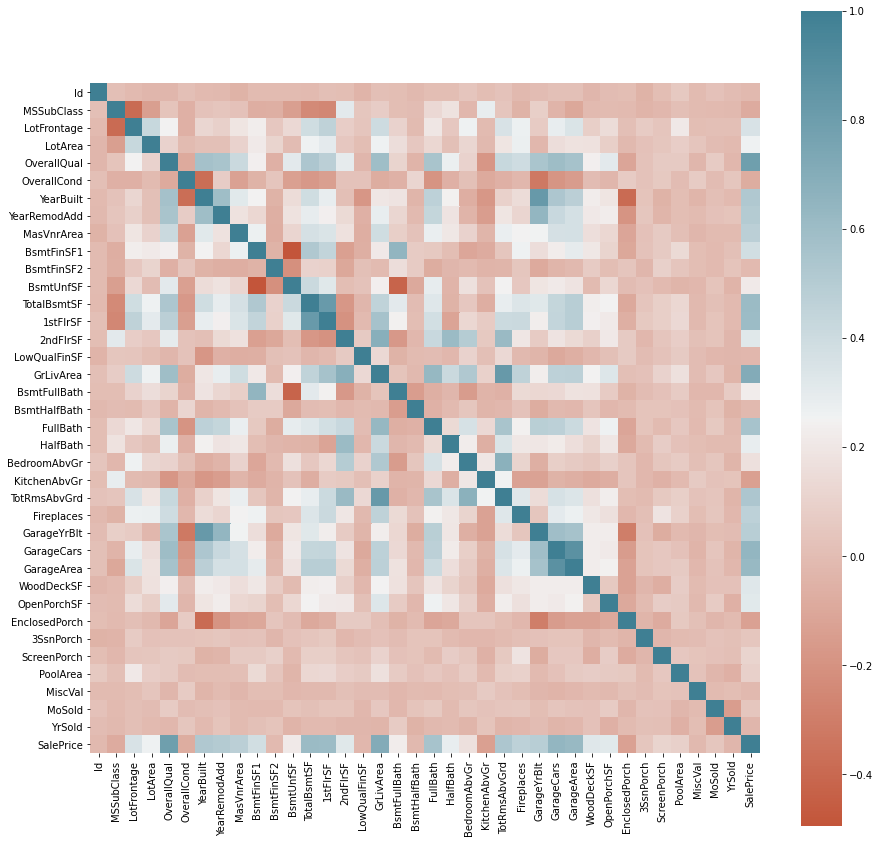

In [4]:
# 1 indicates a perfectly negative linear correlation between two variables
# 0 indicates no linear correlation between two variables
# 1 indicates a perfectly positive linear correlation between two variables

corrmat = data_train.corr()
plt.figure(figsize=(15, 15))
color_scheme = sns.diverging_palette(20, 220, n=200, as_cmap=True)
sns.heatmap(corrmat, cmap=color_scheme, square=True)

<AxesSubplot:>

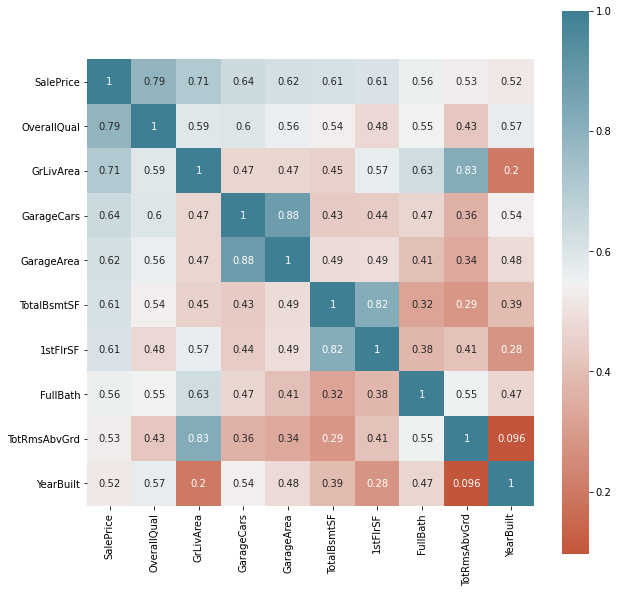

In [5]:
# based on the correlation heatmap, the sale price is more dependent on the following:
#    1. OverallQual
#    2. GrLiveArea
#    3. GarageCars
#    4. GarageArea
#    5. TotalBsmtSF
#    6. 1stFlrSF
# creating a correlation heatmap with these values
cols = corrmat.nlargest(10, 'SalePrice').index
new_cormat = np.corrcoef(data_train[cols].to_numpy().T)

plt.figure(figsize=(10, 10))
sns.heatmap(new_cormat, cmap=color_scheme, annot=True, square=True,
            yticklabels=cols.values, xticklabels=cols.values)

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

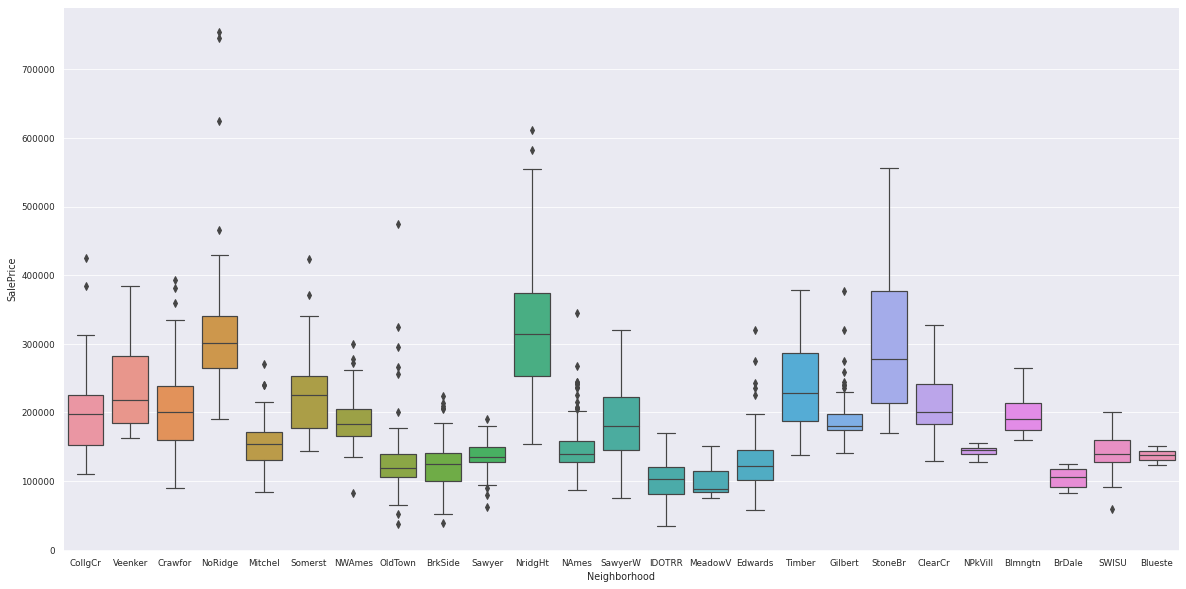

In [6]:
# plotting SalePrice vs Neighbourhood(location)
sns.set(rc={'figure.figsize': (20, 10)})
sns.set_context('paper')
sns.boxplot(x='Neighborhood', y='SalePrice', data=data_train)
# data_train['Neighborhood'].unique()
# data_train[data_train['Neighborhood'] == 'NoRidge']['SalePrice'].describe()

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

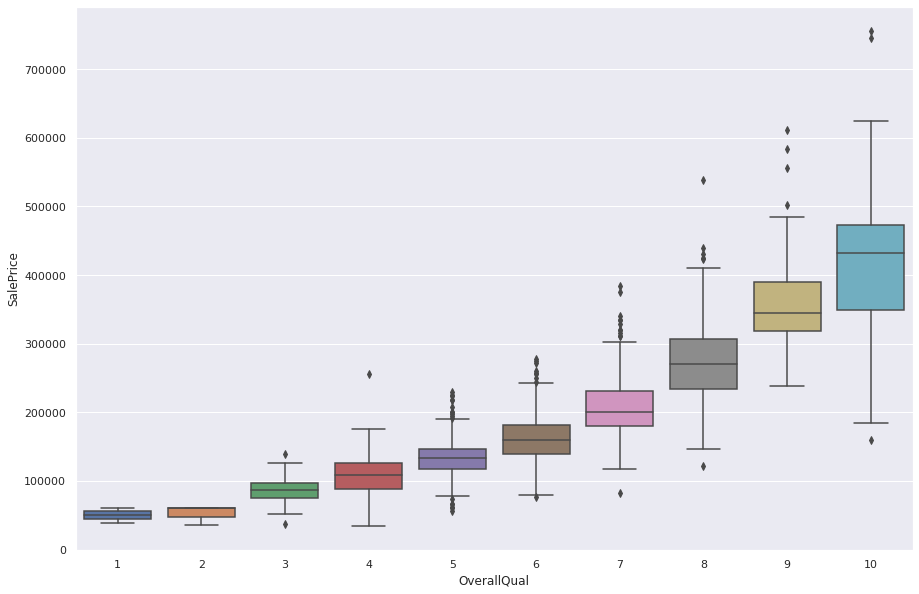

In [7]:
# plotting SalePrice vs OverallQual
sns.set(rc={'figure.figsize': (15, 10)})
sns.boxplot(x='OverallQual', y='SalePrice', data=data_train)

In [8]:
# taking a look at the missing(null) data
missing_total = data_train.isnull().sum().sort_values(ascending=False)
missing_percentage = (data_train.isnull().sum() * 100 / data_train.isnull().count()).sort_values(ascending=False)
missing_cols = pd.concat([missing_total, missing_percentage], keys=['Total', 'Percentage'], axis=1)
missing_cols.head(20)

,Total,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


In [9]:
data_train = data_train.drop(columns=missing_cols[missing_cols['Total']>1].index)
data_train = data_train.drop(data_train.loc[data_train['Electrical'].isnull()].index)
# checking there are no missing values
print(data_train.isnull().sum().max())

0


[-1.83820775 -1.83303414 -1.80044422 -1.78282123 -1.77400974 -1.62295562
 -1.6166617  -1.58519209 -1.58519209 -1.57269236]
[3.82758058 4.0395221  4.49473628 4.70872962 4.728631   5.06034585
 5.42191907 5.58987866 7.10041987 7.22629831]


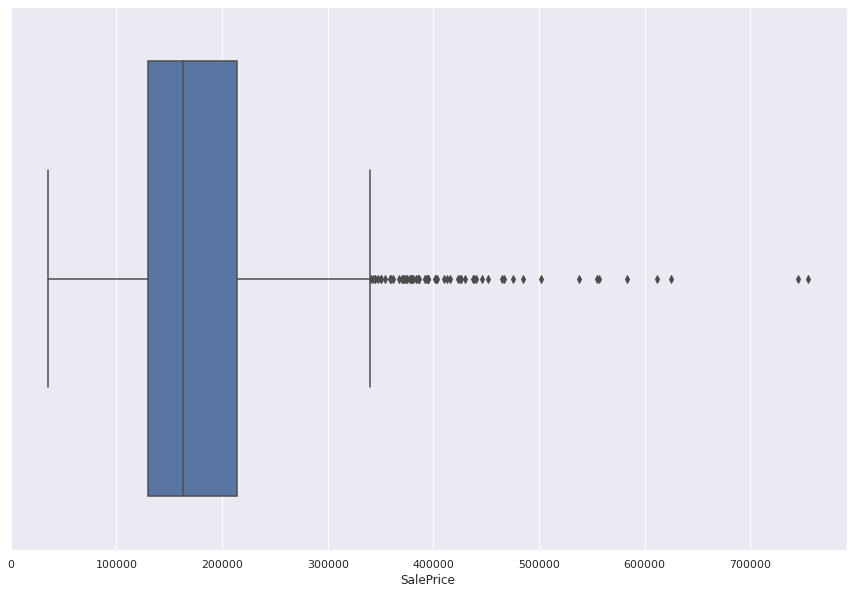

In [10]:
# scaling SalePrice to identify outlieres
saleprice_scaled = StandardScaler().fit_transform(data_train['SalePrice'][:, np.newaxis])
saleprice_scaled = saleprice_scaled.reshape(1459, )
lower_10, upper_10 = np.sort(saleprice_scaled)[:10], np.sort(saleprice_scaled)[-10:]
sns.boxplot(x='SalePrice', y=None, data=data_train)
print(lower_10)
print(upper_10)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


1298    5642
523     4676
1182    4476
691     4316
Name: GrLivArea, dtype: int64


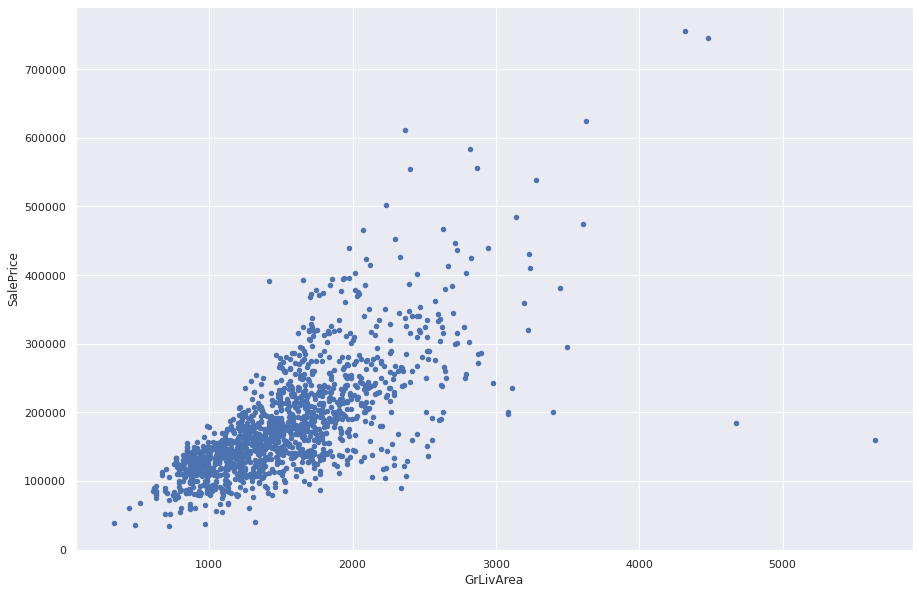

In [11]:
data_train.plot.scatter(x='GrLivArea', y='SalePrice')
# 2 outliers in the rightmost bottom
print(data_train['GrLivArea'].sort_values(ascending=False)[:4])
data_train = data_train.drop(data_train[data_train['GrLivArea'] > 4476].index)

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

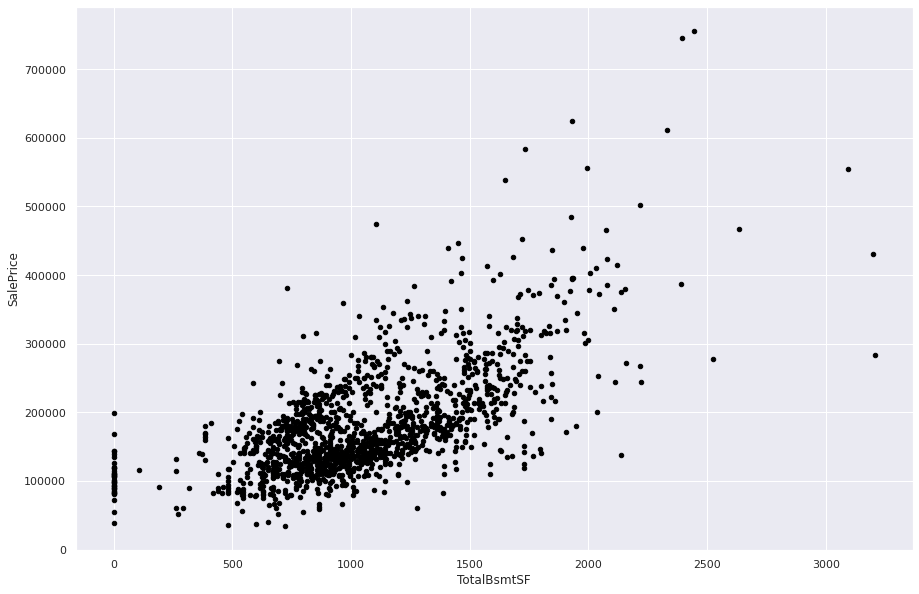

In [12]:
data_train.plot.scatter(x='TotalBsmtSF', y='SalePrice', c='black')
# 3 outliers TotalBsmtSF > 3000

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

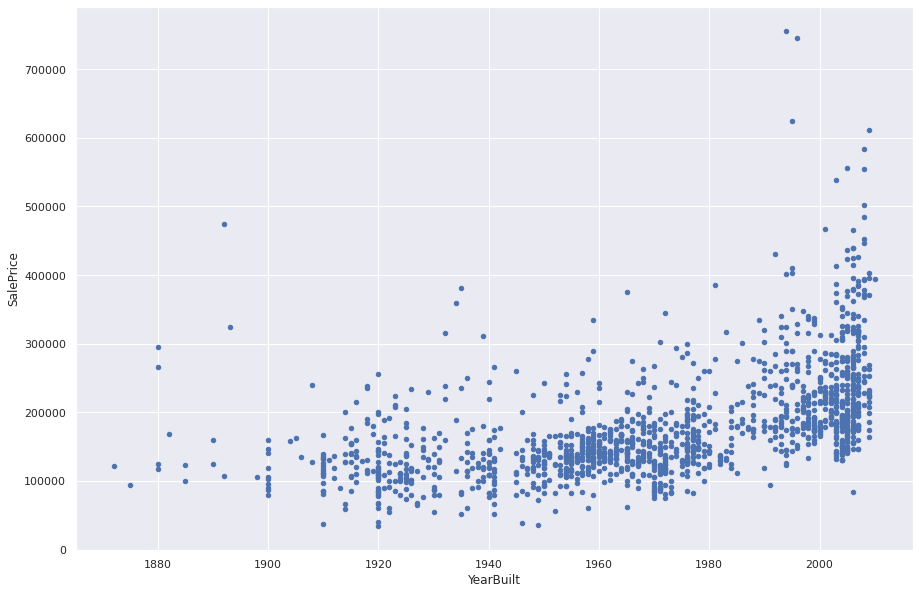

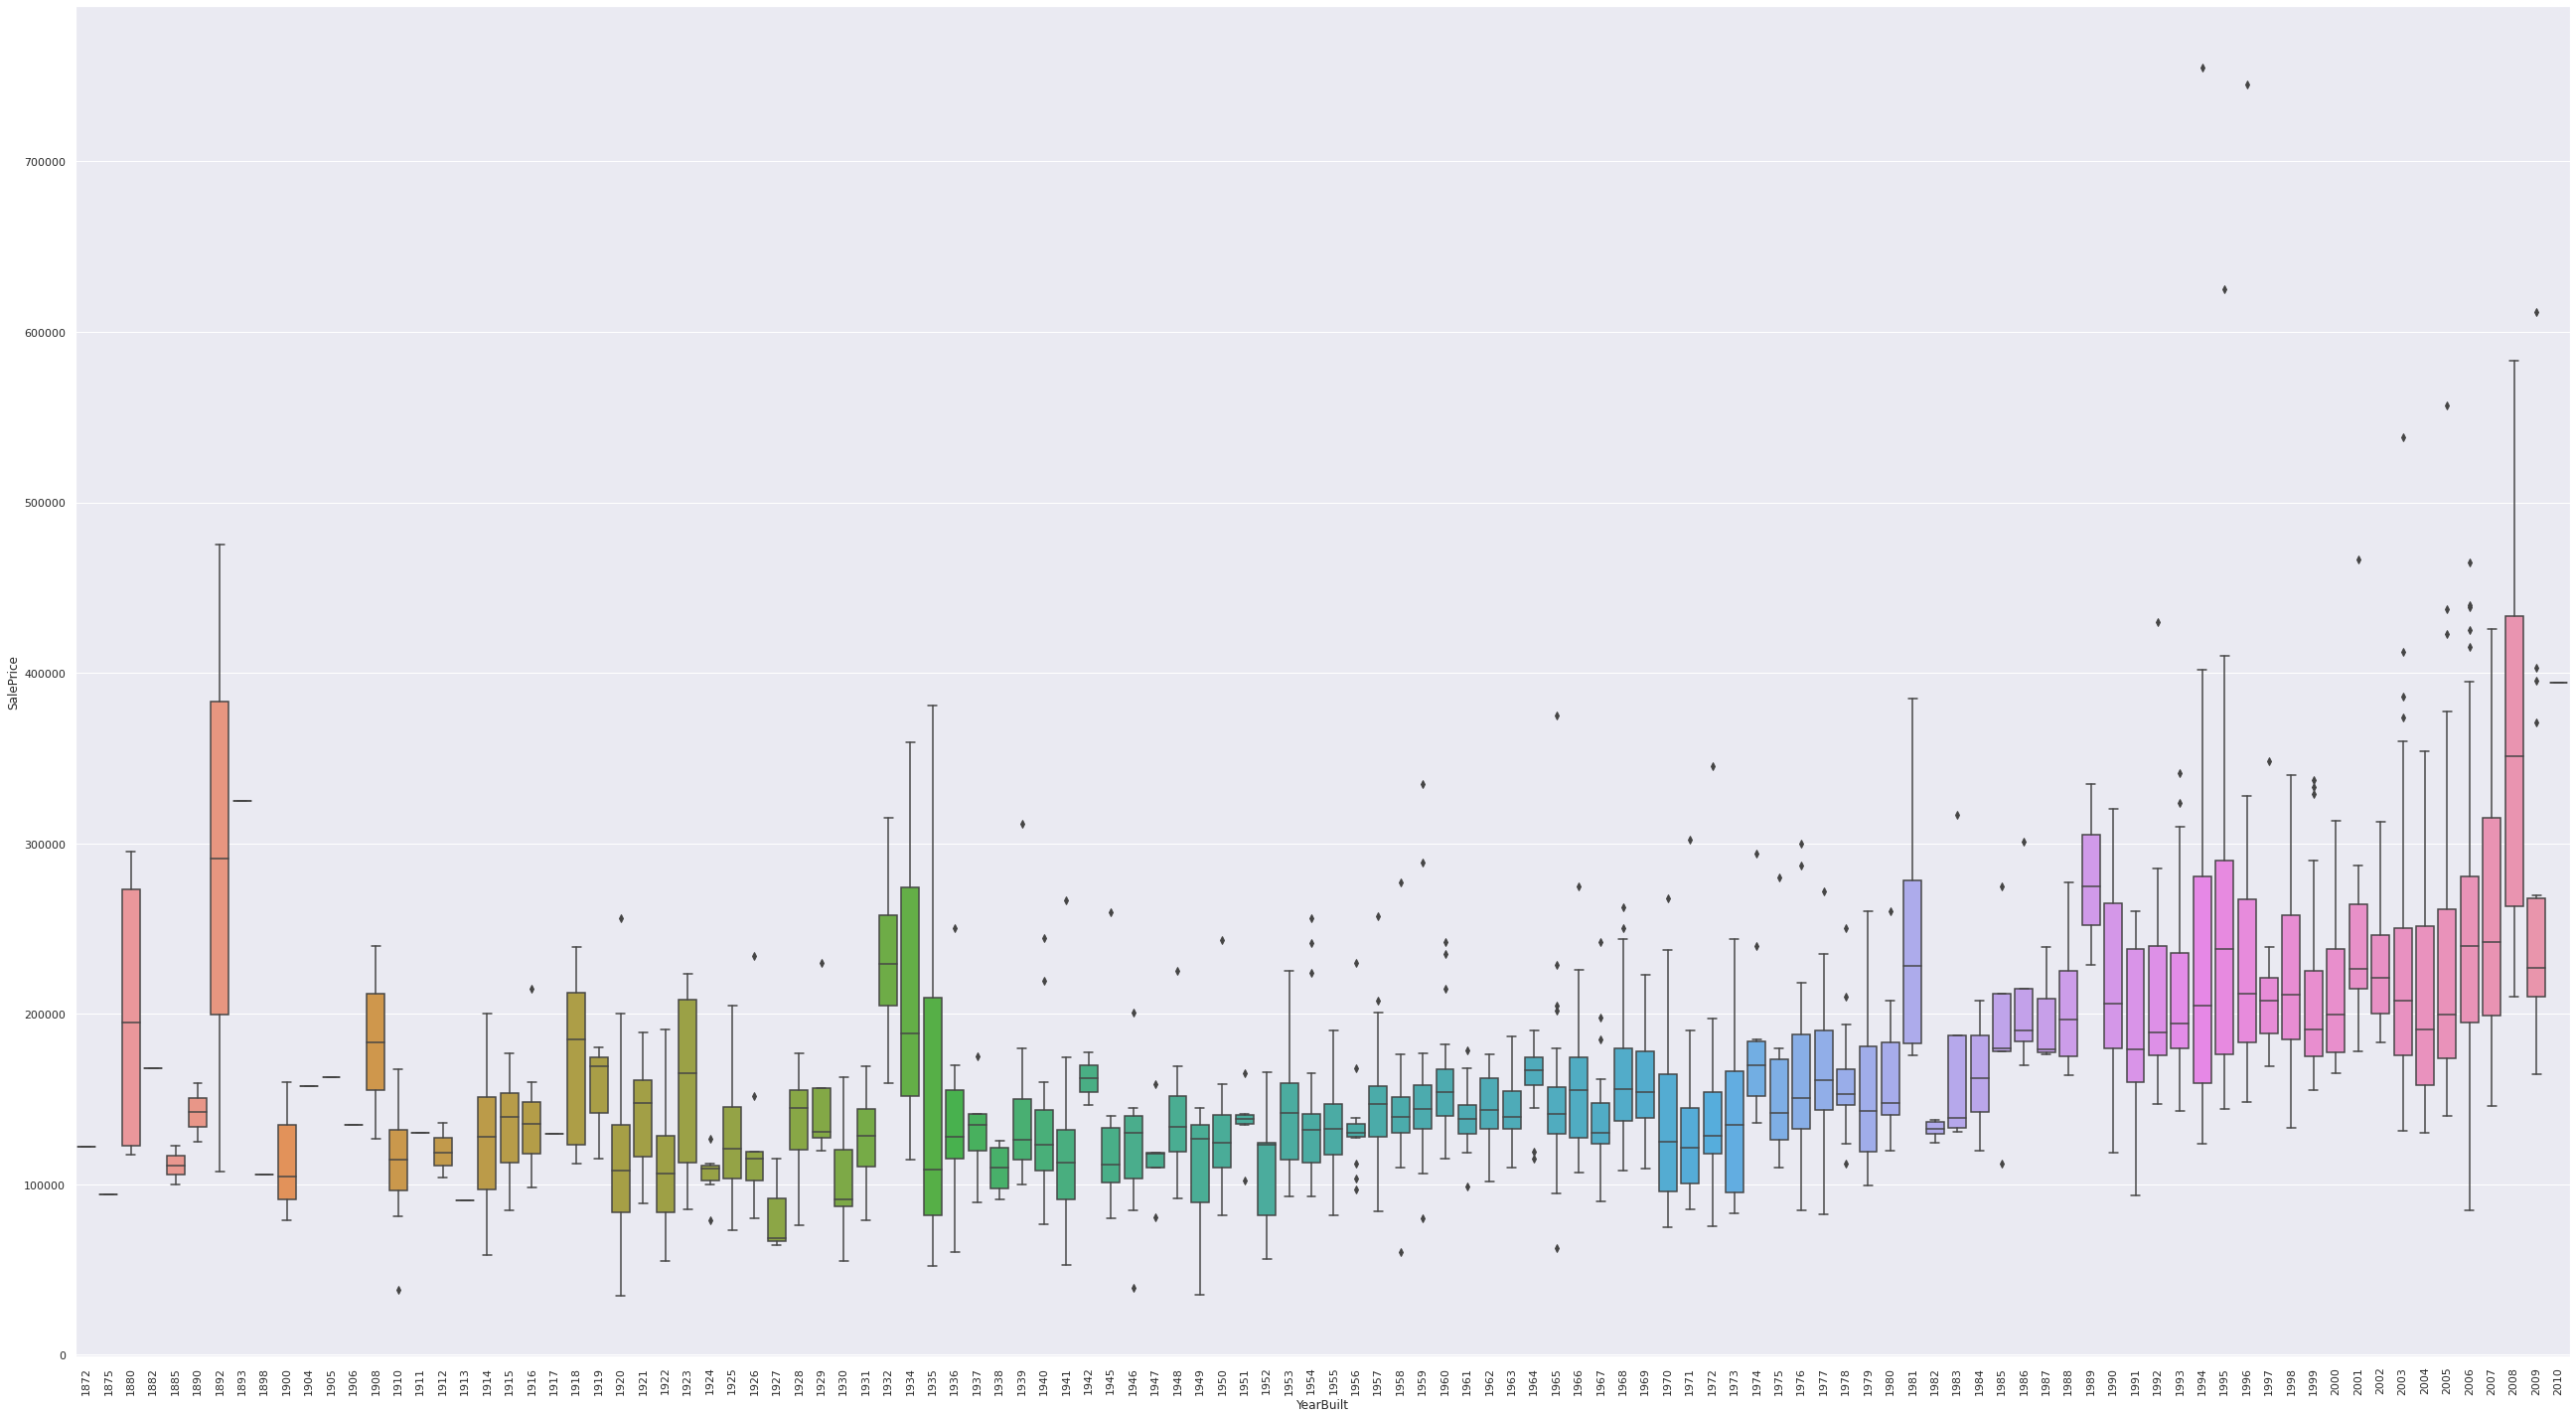

In [13]:
data_train.plot.scatter(x='YearBuilt', y='SalePrice')
plt.figure(figsize=(45,25))
plt.xticks(rotation=90)
sns.boxplot(x='YearBuilt', y='SalePrice', data=data_train)

In [14]:
# dropping outliers with SalePrice > 600000 and YearBuilt > 1993
data_train = data_train.drop(data_train[np.logical_and((data_train['YearBuilt'] > 1993), (data_train['SalePrice'] > 600000))].index)